In [ ]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
# Parameters
samples = 20000
learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09
loss_function = "sparse_categorical_crossentropy"
# You'll need to download the dataset images if you want to visualize them
# For now, we'll skip the image loading parts and focus on the model


In [ ]:
# Load data
df = pd.read_csv("/content/train.csv")
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [ ]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)


Size of training data: (20001, 3)
Number of unique classes: 16342


In [ ]:
# Analyze class distribution
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace=True)
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())  # statistical data for the distribution

   landmark_id  count
0       138982     57
1       177870     22
2        62798     20
3       192931     16
4       176528     14
5       171772     14
6        83144     14
7        45428     11
8       126637     10
9        10618     10
       landmark_id  count
16332        37007      1
16333        30748      1
16334       174045      1
16335        76112      1
16336        18915      1
16337       149463      1
16338         6545      1
16339       169098      1
16340        22745      1
16341       154008      1
count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64


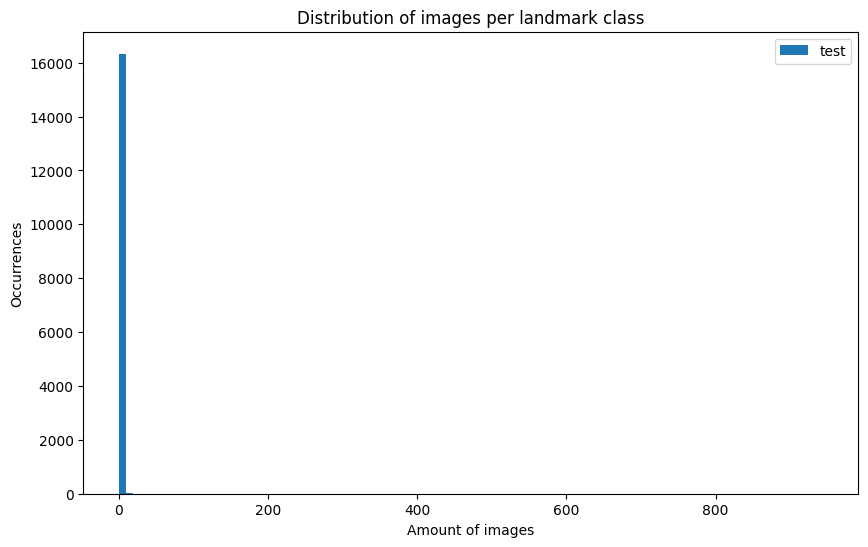

In [ ]:
# Plot histogram of class distribution
plt.figure(figsize=(10, 6))
plt.hist(data['count'], 100, range=(0, 944), label='test')
plt.xlabel("Amount of images")
plt.ylabel("Occurrences")
plt.title("Distribution of images per landmark class")
plt.legend()
plt.show()

In [ ]:
print("Amount of classes with less than or equal to five datapoints:", (data['count'] <= 5).sum())
print("Amount of classes between five and 10 datapoints:", ((data['count'] > 5) & (data['count'] <= 10)).sum())

Amount of classes with less than or equal to five datapoints: 16281
Amount of classes between five and 10 datapoints: 53


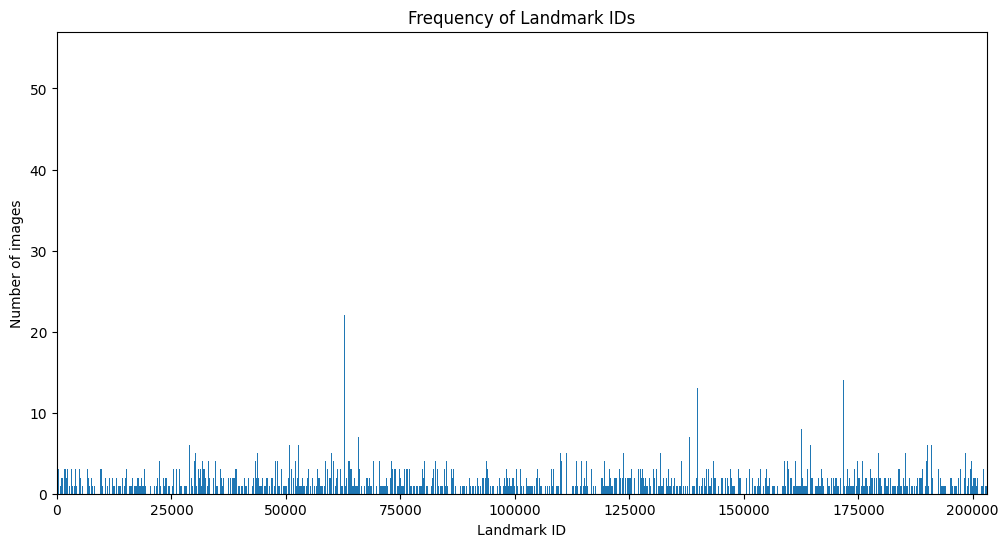

In [ ]:
# Plot frequency of landmark IDs
plt.figure(figsize=(12, 6))
n = plt.hist(df["landmark_id"], bins=len(df["landmark_id"].unique()))
freq_info = n[0]
plt.xlim(0, data['landmark_id'].max())
plt.ylim(0, data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')
plt.title('Frequency of Landmark IDs')
plt.show()

In [ ]:
# Label encoding
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])


LabelEncoder()

In [ ]:
def encode_label(lbl):
    return lencoder.transform(lbl)


In [ ]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)


In [ ]:
# Function definition for when you have the image dataset available
def get_image_from_number(num):
    """
    This function will work once you have downloaded the image dataset.
    For now, it's included as a reference but won't be called.

    Usage:
    base_path = "/path/to/downloaded/images"
    image, label = get_image_from_number(42)
    """
    fname, label = df.iloc[num]  # Use iloc instead of loc for integer-based indexing
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1, f2, f3, fname)
    # This will only work when base_path is properly defined and images are available
    # im = cv2.imread(os.path.join(base_path, path))
    # return im, label
    print("Warning: Images not available. Function provided for reference only.")
    return None, label

In [ ]:
# Skip image display since we don't have the image files
print("Image display skipped - dataset images not available locally")

# To use this feature, you would need to download the Google Landmarks dataset images
# You could use:
# !mkdir -p /content/landmark_images
# !wget -q [URL_TO_DATASET] -O dataset.zip
# !unzip -q dataset.zip -d /content/landmark_images
# base_path = "/content/landmark_images"


Image display skipped - dataset images not available locally


In [ ]:
# Create model
source_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))  # Specify input shape


In [ ]:
# Create a sequential model
model = Sequential()


In [ ]:
# Add the VGG19 layers (except the top)
for layer in source_model.layers:
    model.add(layer)

In [ ]:
# Flatten the output of the VGG19 model
model.add(Flatten())


In [ ]:
# Add dropout for regularization
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))


In [ ]:
# Add the output layer
model.add(Dense(num_classes, activation="softmax"))


In [ ]:
# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 206,523,414 (787.82 MB)

 Trainable params: 206,523,414 (787.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
from keras.optimizers import SGD # Make sure SGD is imported

optim1 = SGD(learning_rate=learning_rate, decay=decay_speed, momentum=momentum) # Create an instance of the SGD optimizer
model.compile(optimizer=optim1,
             loss=loss_function,
             metrics=["accuracy"])

print("Model compiled!")

Model compiled!


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
